## Computes PV curves using xenon equation of state

https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.testing as npt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2017-12-06 10:51:48


In [2]:
from operator import itemgetter, attrgetter

In [6]:
from pynext.system_of_units import *
from pynext.XenonES import XenonES
from pynext.XenonES import XeHe

In [7]:
from math import pi, sqrt, exp, log

In [8]:
from IPython.display import Image

## Constants

In [60]:
M = 131.29 # g/mol
MXe = 131.29 # g/mol
MHe = 4 # g/mol
RM = 8.31441 # J/(K * mol) 
R = (RM / M) * J/(K * gram) 
RXe = (RM / MXe) * J/(K * gram)
RHe = (RM / MHe) * J/(K * gram)
k = 1.38064852 * 1E-23 * J/K 
N_A = 6.02214129E+23 * (1./mol)
T0 = 273.15 # 0 in K
rho_2020 = 124.3 * kg/m3
rho_3020 = 203.35 * kg/m3
rho_1520 = 89.9 * kg/m3
rho_1020 = 58 * kg/m3
rho_0520 = 30 * kg/m3
rho_0720 = 40 * kg/m3
rho_0920 = 50 * kg/m3
rho_list = [
('rho_2020' , rho_2020),
('rho_3020' , rho_3020),
('rho_1520' , rho_1520),
('rho_1020' , rho_1020),
('rho_0520' , rho_0520),
('rho_0720' , rho_0720),
('rho_0920' , rho_0920)
]
rho_ref = 5.9 * kg/m3

Reference values

T = 273.15 

P = 0.101 MPa

rho = 5.9 kg/m3

In [10]:
xe = XenonES()

In [11]:
def print_densities(densities):
    
    ug = g/cm3
    ukg = kg/m3
    ordered = sorted([ (name, r) for (name, r) in densities ],
                     key=itemgetter(1))
    
    for name, r in ordered:
        print("""{} = {:7.2f} g/cm3 ({:7.2f} kg/m3) is the density at which 
              P = {:7.2f} atm (P_perfect = {:7.2f} atm) and T = 20C'.""".format(name, r/ug, r/ukg,
                 xe.P(20, r, perfect=False) / atmosphere,
                 xe.P(0, r, perfect=True) / atmosphere))
   

In [49]:
def select_phase(npdata, rho=2700):
    liquid = npdata[np.where(npdata[:,2] > rho)[0]]
    gas = npdata[np.where(npdata[:,2] < rho)[0]]
    return liquid, gas
    

In [51]:
def t_and_p(npdata):
    return npdata[:,0], npdata[:,1]

## Density values

### rho = 5.9 kg/m3 is the density at which P = 1 atm and T = 0 C

In [12]:
npt.assert_allclose(xe.P(T=0, RHO=rho_ref, perfect=True) / atmosphere, 1, rtol=1e-02, atol=1e-02)

In [13]:
npt.assert_allclose(xe.P(T=0, RHO=rho_ref, perfect=False) / atmosphere, 1, rtol=1e-02, atol=1e-02)

### several values of density

In [61]:
print_densities(rho_list)

rho_0520 =    0.03 g/cm3 (  30.00 kg/m3) is the density at which 
              P =    5.33 atm (P_perfect =    5.12 atm) and T = 20C'.
rho_0720 =    0.04 g/cm3 (  40.00 kg/m3) is the density at which 
              P =    7.04 atm (P_perfect =    6.83 atm) and T = 20C'.
rho_0920 =    0.05 g/cm3 (  50.00 kg/m3) is the density at which 
              P =    8.70 atm (P_perfect =    8.53 atm) and T = 20C'.
rho_1020 =    0.06 g/cm3 (  58.00 kg/m3) is the density at which 
              P =   10.01 atm (P_perfect =    9.90 atm) and T = 20C'.
rho_1520 =    0.09 g/cm3 (  89.90 kg/m3) is the density at which 
              P =   15.01 atm (P_perfect =   15.34 atm) and T = 20C'.
rho_2020 =    0.12 g/cm3 ( 124.30 kg/m3) is the density at which 
              P =   20.00 atm (P_perfect =   21.21 atm) and T = 20C'.
rho_3020 =    0.20 g/cm3 ( 203.35 kg/m3) is the density at which 
              P =   30.00 atm (P_perfect =   34.70 atm) and T = 20C'.


## Equation of gases at various densities

In [15]:
T = np.arange(-100, 25, 0.5)

In [42]:
P10 = np.array([xe.P(t, rho_1020, perfect=False) for t in T]) / atmosphere
P20 = np.array([xe.P(t, rho_2020, perfect=False) for t in T]) / atmosphere
P30 = np.array([xe.P(t, rho_3020, perfect=False) for t in T]) / atmosphere
P05 = np.array([xe.P(t, rho_0520, perfect=False) for t in T]) / atmosphere

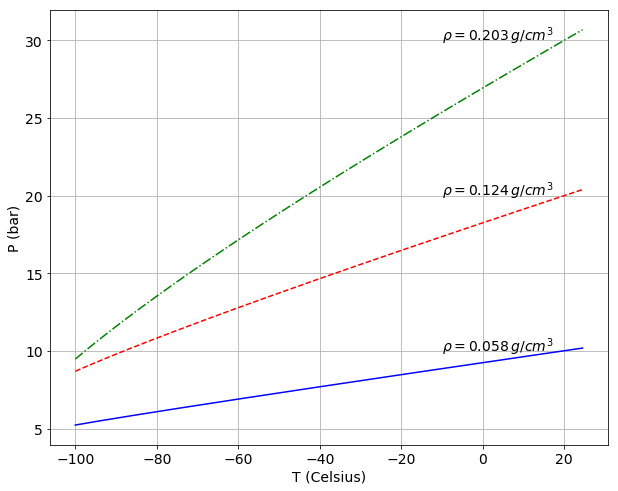

In [17]:
plt.plot(T,P10,'b')
plt.plot(T,P20,'r--')
plt.plot(T,P30,'g-.')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(-10, 30, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_3020/ (g/cm3)))
plt.text(-10, 20, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_2020/ (g/cm3)))
plt.text(-10, 10, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_1020/ (g/cm3)))
plt.show()

In [22]:
np0520 = np.loadtxt('rho_0520.txt', comments='#', usecols=(0,1,6))

In [52]:
liquid_0520, gas_0520 = select_phase(np0520)

In [53]:
T_l0520,  P_l0520 = t_and_p(liquid_0520)
T_g0520,  P_g0520 = t_and_p(gas_0520)

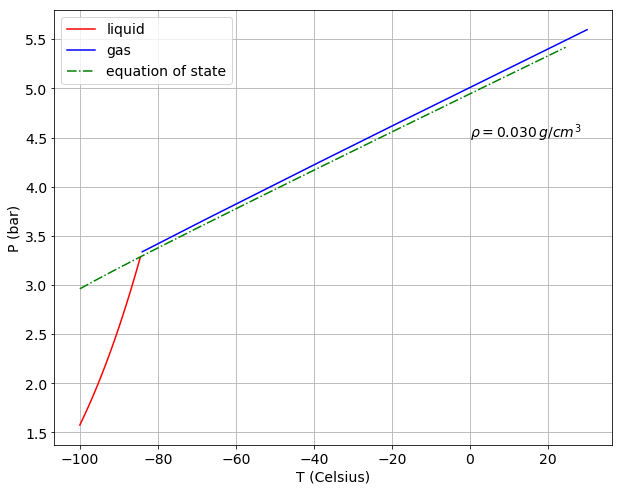

In [54]:
plt.plot(T_l0520,P_l0520,'r')
plt.plot(T_g0520,P_g0520,'b')
plt.plot(T,P05,'g-.')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(0, 4.5, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_0520/ (g/cm3)))
plt.legend(['liquid','gas','equation of state'])
#plt.text(-10, 10, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_1020/ (g/cm3)))
plt.show()

In [55]:
ls


pyNEXT.ipynb    rho_0520.txt    rho_0720.txt    rho_0920.txt    xenon_pv.ipynb


In [56]:
np0720 = np.loadtxt('rho_0720.txt', comments='#', usecols=(0,1,6))
np0920 = np.loadtxt('rho_0920.txt', comments='#', usecols=(0,1,6))

In [57]:
liquid_0720, gas_0720 = select_phase(np0720)
T_l0720,  P_l0720 = t_and_p(liquid_0720)
T_g0720,  P_g0720 = t_and_p(gas_0720)
liquid_0920, gas_0920 = select_phase(np0920)
T_l0920,  P_l0920 = t_and_p(liquid_0920)
T_g0920,  P_g0920 = t_and_p(gas_0920)

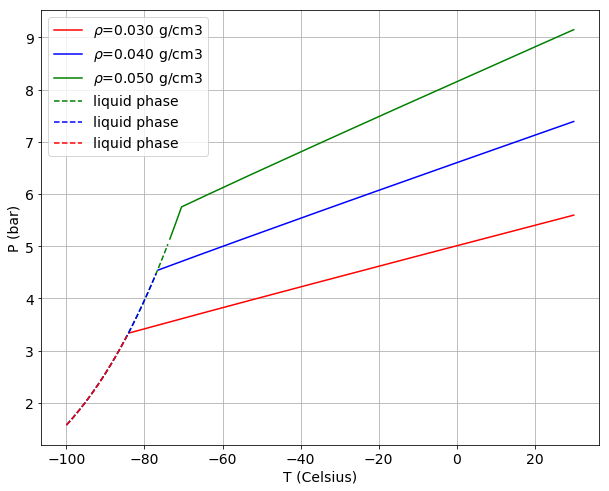

In [73]:
plt.plot(T_g0520,P_g0520,'r')
plt.plot(T_g0720,P_g0720,'b')
plt.plot(T_g0920,P_g0920,'g')
plt.plot(T_l0920,P_l0920,'g--')
plt.plot(T_l0720,P_l0720,'b--')
plt.plot(T_l0520,P_l0520,'r--')


plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
#plt.text(0, 4.5, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_0520/ (g/cm3)))
plt.legend([r'$\rho$={0:5.3f} g/cm3'.format(rho_0520/ (g/cm3)),
            r'$\rho$={0:5.3f} g/cm3'.format(rho_0720/ (g/cm3)),
            r'$\rho$={0:5.3f} g/cm3'.format(rho_0920/ (g/cm3)),
            'liquid phase','liquid phase','liquid phase'])
#plt.text(-10, 10, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_1020/ (g/cm3)))
plt.show()

In [76]:
P30P = np.array([xe.P(t, rho_3020, perfect=True) for t in T]) / atmosphere

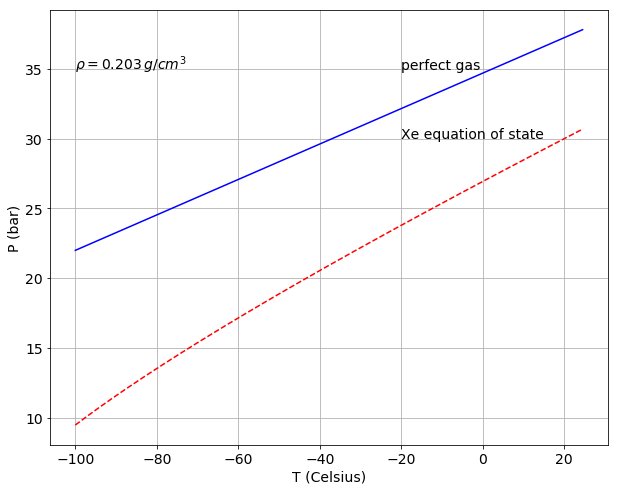

In [78]:
plt.plot(T,P30P,'b')
plt.plot(T,P30,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.text(-100, 35, r'$\rho={0:5.3f} \, g/cm^3$'.format(rho_3020/ (g/cm3)))
plt.text(-20, 35, r'perfect gas')
plt.text(-20, 30, r'Xe equation of state')
#plt.text(-100, 35, r'https://www.nist.gov/sites/default/files/documents/srd/jpcrd470.pdf')
plt.show()

In [31]:
Tc = 198.15 #-75 C

### Second virial coefficient

In [14]:

# xenon
sigma = 0.3885 * nm
ek    = 274 * K # epsilon/k

Tc = 198.15 #-75 C
print('Tc/ek = {}'.format(Tc/ek))
Ls    = 0.06    # Lambda* 
Ls2   = Ls*Ls    # (Lambda*)^2 
Ls3   = Ls2*Ls    # (Lambda*)^3
Ls4   = Ls2*Ls2    # (Lambda*)^4
Ls6   = Ls4*Ls2    # (Lambda*)^4

uB = 1E-3 * meter3/kmol

Tc/ek = 0.7231751824817518


### Check that equation of State and 2nd Virial yield same result

In [37]:
T = np.arange(-100, 25, 0.5)
PF = np.array([xe.P(t, rho_2020, perfect=False) for t in T]) / atmosphere
PT = np.array([xe.P(t, rho_2020, perfect=True) for t in T]) / atmosphere
PF2 = np.array([xe.P2(t, rho_2020, perfect=False) for t in T]) / atmosphere
PT2 = np.array([xe.P2(t, rho_2020, perfect=True) for t in T]) / atmosphere

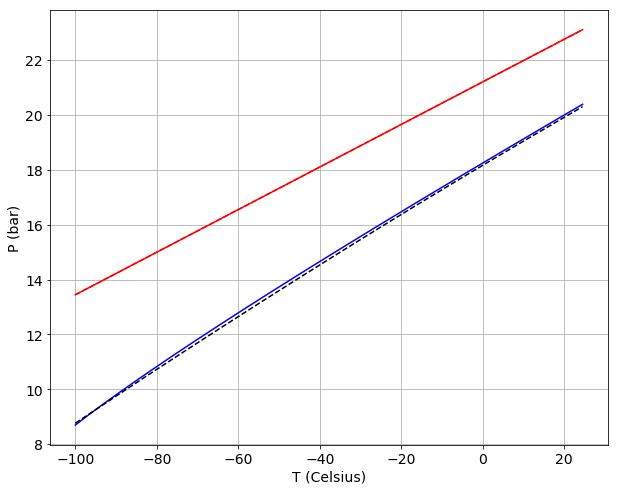

In [38]:
plt.plot(T,PF,'b')
plt.plot(T,PF2,'k--')
plt.plot(T,PT,'r')
plt.plot(T,PT2,'r--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
plt.show()

### Xenon Helium mixtures

In [84]:
xehe = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=0.5, xXe=0.5)

In [85]:
print(xehe)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 380.8363165511463)   = 0.5 mol
            nHe  (XHe = 380.8363165511463)   = 0.5 mol
            PXe               = 8.138254123487801 atm
            PHe               = 8.138254123487801 atm
            P                 = 16.276508246975602 atm
            


In [86]:
xehe.pXe(tc=-90) /atmosphere

5.084500230997069

In [87]:
xehe.pHe(tc=-90) /atmosphere

5.084500230997069

In [88]:
xehe.p(tc=-90) /atmosphere

10.169000461994138

In [89]:
xehe.pBXe(tc=-90) /atmosphere

4.945958669606906

In [90]:
xehe.pBHe(tc=-90) /atmosphere

4.945958669606906

In [91]:
xehe.pB(tc=-90) /atmosphere

9.891917339213812

In [92]:
xe = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=0., xXe=1.0)
he = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=1., xXe=0.0)
xehe_8515 = XeHe(m=100 * kg, V=(105/2)**2 * 130 * pi * cm3, tc=20, xHe=0.15, xXe=0.85)

In [93]:
print(xe)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 761.6726331022926)   = 1.0 mol
            nHe  (XHe = 0.0)   = 0.0 mol
            PXe               = 16.276508246975602 atm
            PHe               = 0.0 atm
            P                 = 16.276508246975602 atm
            


In [94]:
print(he)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 0.0)   = 0.0 mol
            nHe  (XHe = 761.6726331022926)   = 1.0 mol
            PXe               = 0.0 atm
            PHe               = 16.276508246975602 atm
            P                 = 16.276508246975602 atm
            


In [95]:
print(xehe_8515)


            m    (XHe = 1)    = 100.0 kg
            V                 = 1.1256719176893928 m3
            n0Xe (XHe = 1)    = 761.6726331022926 mol
            rho  (XHe = 1)    = 0.08883583078563842 g/cm3
            P0   (XHe = 1)    = 16.276508246975602 atm
            nXe  (XHe = 647.4217381369486)   = 0.85 mol
            nHe  (XHe = 114.25089496534389)   = 0.15 mol
            PXe               = 13.83503200992926 atm
            PHe               = 2.4414762370463405 atm
            P                 = 16.276508246975602 atm
            


In [96]:
15*0.15

2.25

In [97]:
xehe_8515.p(20) / atmosphere

16.276508246975602

In [98]:
xehe_8515.pB(20) / atmosphere

15.480065095512593

In [99]:
xehe_8515.p(-20) / atmosphere

14.05559632516416

In [100]:
xehe_8515.pB(-20) / atmosphere

13.148500132124799

In [101]:
T = np.arange(-100, 25, 0.5)
PF  = np.array([xe.pB(tc=t) / atmosphere for t in T])
PP  = np.array([xe.p(tc=t) / atmosphere for t in T])
PF2  = np.array([xehe_8515.pB(tc=t) / atmosphere for t in T])
PP2  = np.array([xehe_8515.p(tc=t) / atmosphere for t in T])

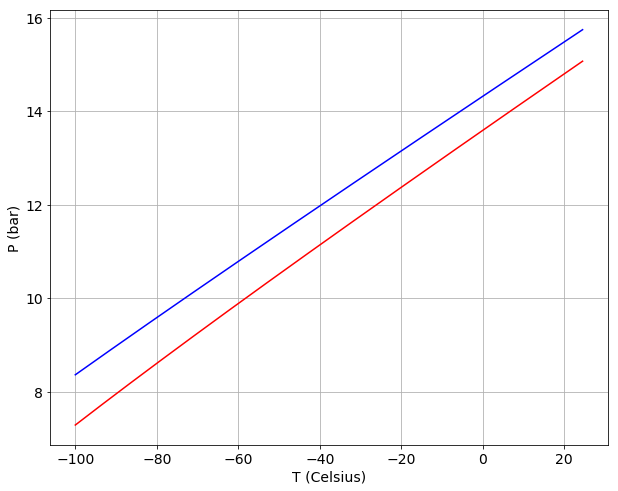

In [102]:
plt.plot(T,PF,'r')
#plt.plot(T,PP,'r--')
plt.plot(T,PF2,'b')
#plt.plot(T,PP2,'b--')
plt.grid(True)
plt.xlabel('T (Celsius)')
plt.ylabel('P (bar)')
#plt.text(-40, 14,'Xe')
#plt.text(-25, 20,'He')
#plt.text(-40, 17,'0.15 * He + 0.85 * Xe')
plt.show()

In [ ]:
Image(filename='./Bolotnikov.png')